<a href="https://colab.research.google.com/github/Togotogo98/Crop_export_value_prediction/blob/main/MLP_Model_276375.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import important libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#CSV file paths
LAND_USE_CSV = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Land use - FAOSTAT_data_en_2-22-2024.csv"
PESTICIDE_USE_CSV = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Pesticides use - FAOSTAT_data_en_2-27-2024.csv"
FOOD_TRADE_INDICATOR_CSV = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Food trade indicators - FAOSTAT_data_en_2-22-2024.csv"
CROP_PROD_INDICATOR_CSV = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Crops production indicators - FAOSTAT_data_en_2-22-2024.csv"
LAND_TEMP_CHANGE_CSV = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Land temperature change - FAOSTAT_data_en_2-27-2024.csv"
EXCHANGE_RATE_CSV = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Exchange rate - FAOSTAT_data_en_2-22-2024.csv"

#dataframes of CSVs
land_use_file = pd.read_csv(LAND_USE_CSV)
pesticide_use_file = pd.read_csv(PESTICIDE_USE_CSV)
food_trad_file = pd.read_csv(FOOD_TRADE_INDICATOR_CSV)
crop_prod_indc_file = pd.read_csv(CROP_PROD_INDICATOR_CSV)
land_temp_file = pd.read_csv(LAND_TEMP_CHANGE_CSV)
exchange_rate_file = pd.read_csv(EXCHANGE_RATE_CSV)


<ipython-input-222-e20f9a27c03b>:10: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use_file = pd.read_csv(LAND_USE_CSV)


In [ ]:
# Crop Trade
def Crop_Trade_Filter(food_trad_file):
  columns = ['Area', 'Year', 'Element', 'Item', 'Value']
  filter_by_element = ['Export Value']
  crop_item = ['Cereals and Preparations', 'Fruit and Vegetables']
  filtered = food_trad_file.loc[(food_trad_file['Element'].isin(filter_by_element)) & (food_trad_file['Item'].isin(crop_item)), columns]
  crop_trade = filtered.groupby(['Area', 'Year'])['Value'].sum().reset_index()

  return crop_trade.rename(columns={'Value': 'Crop_Trade'})

# Land Use
def Land_Use_Filter(land_use_file):
  columns = ['Area', 'Year', 'Item', 'Unit', 'Value']
  filter_by_items = [
    'Agricultural land',
    'Cropland',
    'Permanent crops',
    'Temporary crops'
    ]
  filtered = land_use_file.loc[land_use_file['Item'].isin(filter_by_items), columns]

  land_use = filtered.groupby(['Area', 'Year'])['Value'].sum().reset_index()
  return land_use.rename(columns={'Value': 'Land_Use'})

# Crop Produce Indicator
def Crop_Prod_Filter(crop_prod_indc_file):
    columns = ['Area', 'Year', 'Item', 'Value']
    crop_item = [
        'Cereals, primary',
        'Citrus Fruit, Total',
        'Fibre Crops, Fibre Equivalent',
        'Fruit Primary',
        'Pulses, Total',
        'Vegetables Primary'
    ]
    filtered = crop_prod_indc_file.loc[(crop_prod_indc_file['Item'].isin(crop_item)), columns]
    crop_prod_rate = filtered.groupby(['Area', 'Year'])['Value'].sum().reset_index()
    return crop_prod_rate.rename(columns={'Value': 'Crop_Prod'})

# Pesticide use
def Pesticide_Use_Filter(pesticide_use_file):
  columns = ['Area', 'Year', 'Element', 'Item', 'Value']
  filter_by_element = ['Agricultural Use']
  pest_item = ['Pesticides (total)']
  filtered = pesticide_use_file.loc[(pesticide_use_file['Element'].isin(filter_by_element)) & (pesticide_use_file['Item'].isin(pest_item)), columns]
  pesticide_use = filtered[['Area', 'Year', 'Value']].reset_index(drop=True)
  return pesticide_use.rename(columns={'Value': 'Pesticide_Use'})

#Land temperature
def Land_Temp_Filter(land_temp_file):
  columns = ['Area', 'Months', 'Year', 'Element', 'Value']
  filter_by_element = ['Temperature change']
  month = ['Meteorological year']
  filtered = land_temp_file.loc[(land_temp_file['Element'].isin(filter_by_element)) & (land_temp_file['Months'].isin(month)), columns]
  land_temp = filtered[['Area', 'Year', 'Value']].reset_index(drop=True)
  return land_temp.rename(columns={'Value': 'Land_Temperature_Change'})

#Exchange Rate
def Exchange_Rate_Filter(exchange_rate_file):
  columns = ['Area', 'Year', 'Value']
  filtered = exchange_rate_file[columns]
  exchange_rate = filtered.groupby(['Area', 'Year'])['Value'].mean().reset_index()
  return exchange_rate.rename(columns={'Value': 'Exchange_Rate'})


In [ ]:
#Extract filtered files

crop_trade = Crop_Trade_Filter(food_trad_file)
land_use = Land_Use_Filter(land_use_file)
crop_prod_rate = Crop_Prod_Filter(crop_prod_indc_file)
pesticide_use = Pesticide_Use_Filter(pesticide_use_file)
land_temp = Land_Temp_Filter(land_temp_file)
exchange_rate = Exchange_Rate_Filter(exchange_rate_file)

In [ ]:
# Merge all dataframes on 'Area' and 'Year' with suffixes to avoid column name conflicts
combined_data = land_use.rename(columns={'Value': 'Value_land_use'})
combined_data = combined_data.merge(crop_prod_rate, on=['Area', 'Year'], how='outer')
combined_data = combined_data.merge(pesticide_use, on=['Area', 'Year'], how='outer')
combined_data = combined_data.merge(land_temp, on=['Area', 'Year'], how='outer')
combined_data = combined_data.merge(exchange_rate, on=['Area', 'Year'], how='outer')
combined_data = combined_data.merge(crop_trade, on=['Area', 'Year'], how='outer')

#only taking >2000 year value due to lack of data from previous years
combined_data = combined_data[combined_data['Year'] >= 2000]

#Target Future_export_value contain crop traded value from 3 yrs into future
combined_data['Future_export_value'] = combined_data.groupby('Area')['Crop_Trade'].shift(-3)
#drop nan values from Future_export_value
combined_data = combined_data.dropna(subset=['Future_export_value'])

#fill rest of the nan values with 0.0 since we dont dont have that data
combined_data = combined_data.fillna(0.0)

In [ ]:
combined_data.head(5)

,Area,Year,Land_Use,Crop_Prod,Pesticide_Use,Land_Temperature_Change,Exchange_Rate,Crop_Trade,Future_export_value
20,Afghanistan,2000,45699.0,294385.0,0.0,0.993,47357.574730,31080.0,47612.0
21,Afghanistan,2001,48204.0,300348.0,0.0,1.311,47500.014520,27110.0,48633.0
22,Afghanistan,2002,47803.0,306540.0,0.0,1.365,3981.907750,31153.0,61497.0
23,Afghanistan,2003,49641.0,309644.0,0.0,0.587,48.762754,47612.0,56334.0
24,Afghanistan,2004,48902.0,317397.0,0.0,1.373,47.845312,48633.0,124467.0


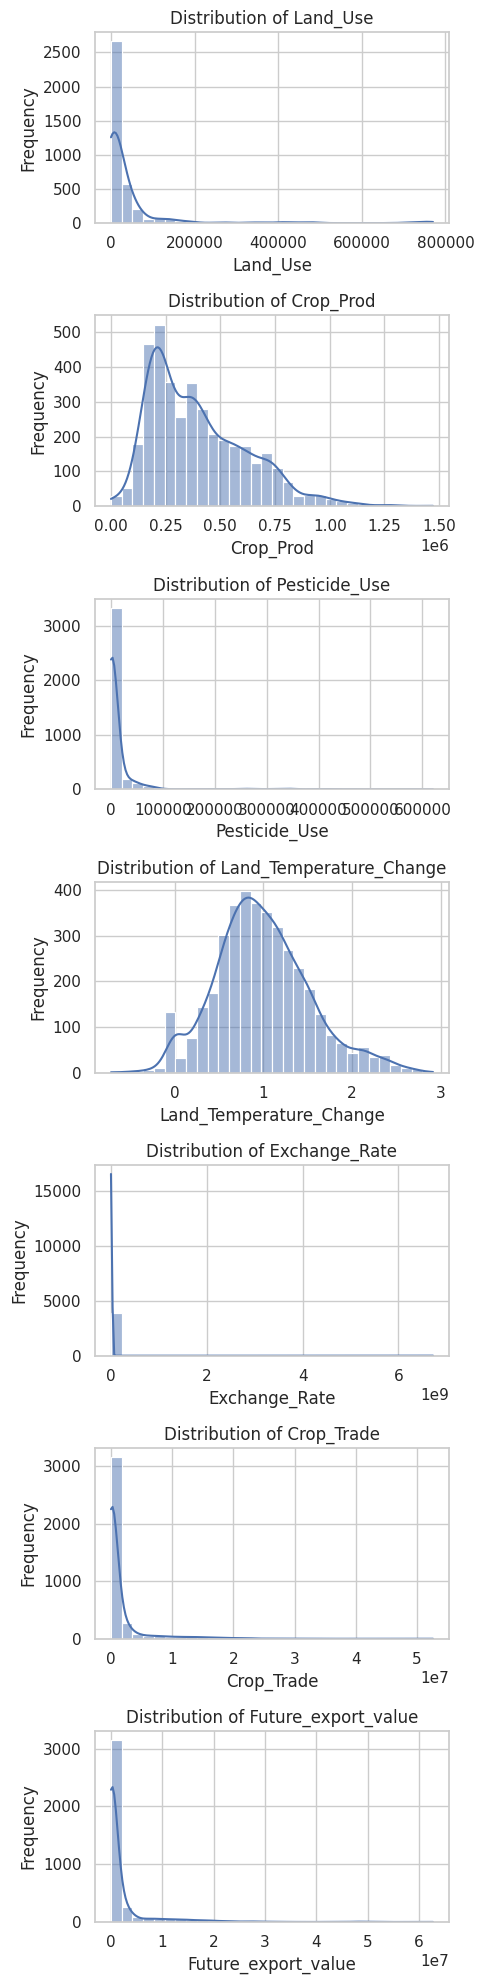

In [ ]:
# Plotting the columns to check the distribution before removing outliers

sns.set(style="whitegrid")

columns = ['Land_Use', 'Crop_Prod', 'Pesticide_Use', 'Land_Temperature_Change', 'Exchange_Rate', 'Crop_Trade', 'Future_export_value']
num_cols = len(columns)
plt.figure(figsize=(5, 20))

for i, column in enumerate(columns):
    plt.subplot(num_cols, 1, i + 1)
    sns.histplot(combined_data[column].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

In [ ]:
# Function to remove outliers using IQR
# Why IQR: the combined_data data has many zero values in the features. That means the data is skewed.
# The IQR method does not assume any specific distribution for the data, making it suitable for
# skewed distributions and data with outliers.
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each relevant column in merged_df
columns_to_check = ['Land_Use', 'Crop_Prod', 'Pesticide_Use', 'Land_Temperature_Change', 'Exchange_Rate', 'Crop_Trade', 'Future_export_value']

for column in columns_to_check:
    combined_data = remove_outliers_iqr(combined_data, column)

In [ ]:
output_path = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/merged_features.csv"
combined_data.to_csv(output_path, index=False)

In [ ]:
combined_data.shape[0]

1802

In [ ]:
# features and target
features = ['Land_Use', 'Crop_Prod', 'Pesticide_Use', 'Land_Temperature_Change', 'Exchange_Rate', 'Crop_Trade']
X = combined_data[features]
y = combined_data['Future_export_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# MLP Model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)#, callbacks=[early_stopping])

Epoch 1/200
36/36 [==============================] - 1s 7ms/step - loss: 15002505216.0000 - val_loss: 11751736320.0000
Epoch 2/200
36/36 [==============================] - 0s 3ms/step - loss: 14376809472.0000 - val_loss: 10337773568.0000
Epoch 3/200
36/36 [==============================] - 0s 3ms/step - loss: 11072478208.0000 - val_loss: 6218883584.0000
Epoch 4/200
36/36 [==============================] - 0s 3ms/step - loss: 6104415744.0000 - val_loss: 3061501184.0000
Epoch 5/200
36/36 [==============================] - 0s 3ms/step - loss: 3771796992.0000 - val_loss: 2332646144.0000
Epoch 6/200
36/36 [==============================] - 0s 3ms/step - loss: 2954802432.0000 - val_loss: 1831514496.0000
Epoch 7/200
36/36 [==============================] - 0s 3ms/step - loss: 2366764800.0000 - val_loss: 1536808832.0000
Epoch 8/200
36/36 [==============================] - 0s 3ms/step - loss: 2030379264.0000 - val_loss: 1431044224.0000
Epoch 9/200
36/36 [==============================] - 0s 3ms

In [ ]:
# Make predictions
y_pred = model.predict(X_test_scaled)

12/12 [==============================] - 0s 3ms/step


In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test set: {mse}')

Mean Squared Error on test set: 2214379483.7550178


In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared for the predictions
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.8056432251688352


In [ ]:
#displaying the results
y_test = pd.Series(y_test, index=X_test.index)

results = pd.DataFrame({
    'Area': combined_data.loc[X_test.index, 'Area'],
    'Current Year': combined_data.loc[X_test.index, 'Year'],
    '3yrs Year later': combined_data.loc[X_test.index, 'Year']+3,
    'Acutal Export Value 3yrs later': combined_data.loc[X_test.index, 'Future_export_value'],
    'Predicted Value(1000 USD)': y_pred.flatten()
})

results.head(10)


,Area,Current Year,3yrs Year later,Acutal Export Value 3yrs later,Predicted Value
9440,"China, Macao SAR",2009,2012,9464.00,9682.678711
1411,Cameroon,2011,2014,97708.55,132764.140625
5192,Mauritania,2014,2017,39.65,19754.939453
674,Barbados,2006,2009,12128.00,12086.272461
6344,Palestine,2019,2022,56145.76,57713.210938
249,Angola,2019,2022,19264.50,67408.648438
995,Bosnia and Herzegovina,2015,2018,166883.82,169154.281250
3627,Guinea-Bissau,2008,2011,203862.00,110012.640625
7655,Somalia,2005,2008,308.00,18188.357422
5070,Malta,2007,2010,19122.00,18446.804688


In [ ]:
output_path = "/content/drive/My Drive/ML Assignment/ML Coursework Dataset/Prediction_Results.csv"
results.to_csv(output_path, index=False)

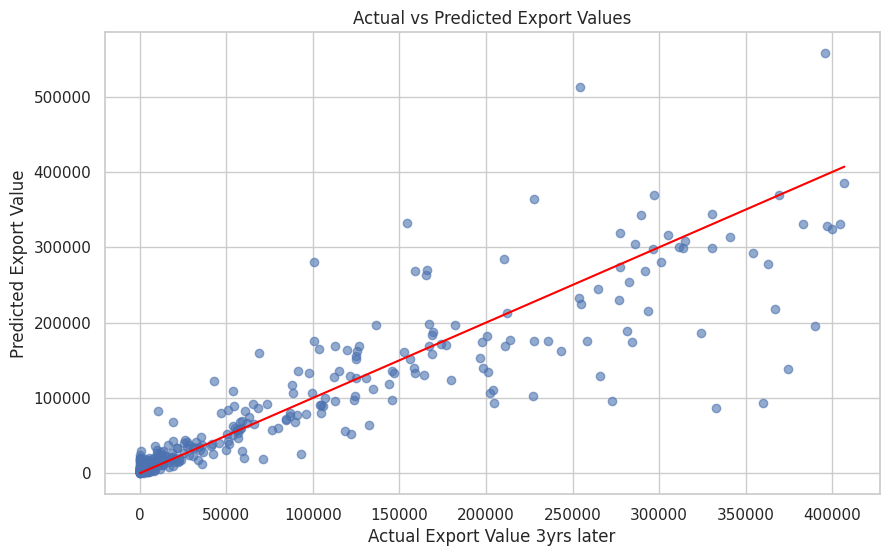

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Export Value 3yrs later')
plt.ylabel('Predicted Export Value')
plt.title('Actual vs Predicted Export Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()